In [ ]:
import cv2
import pywt
import numpy as np


def textToBinary(text):
    return ''.join(format(ord(c), '08b') for c in text)

def bitsToText(bits):
    chars = [bits[i:i+8] for i in range(0, len(bits), 8)]
    return ''.join([chr(int(char, 2)) for char in chars if len(char) == 8])


def encodeDWT(image, text, channel=0, alpha=0.1):
    bits = textToBinary(text)
    img = image.astype(np.float32) / 255.0

    planes = list(cv2.split(img))  

    coeffs2 = pywt.dwt2(planes[channel], 'haar')
    cA, (cH, cV, cD) = coeffs2

    h, w = cD.shape
    bit_idx = 0

    for y in range(h):
        for x in range(w):
            if bit_idx >= len(bits):
                break
            bit = int(bits[bit_idx])
            if bit == 1:
                cD[y, x] += alpha
            else:
                cD[y, x] -= alpha
            bit_idx += 1
        if bit_idx >= len(bits):
            break

    coeffs2 = (cA, (cH, cV, cD))
    modified_plane = pywt.idwt2(coeffs2, 'haar')

    planes[channel] = modified_plane
    merged = cv2.merge(planes)
    return (merged * 255).clip(0, 255).astype(np.uint8)


def decodeDWT(original_img, stego_img, message_length, channel=0):
    original = original_img.astype(np.float32) / 255.0
    stego = stego_img.astype(np.float32) / 255.0

    origPlanes = list(cv2.split(original))
    stegoPlanes = list(cv2.split(stego))

    _, (_, _, cD1) = pywt.dwt2(origPlanes[channel], 'haar')
    _, (_, _, cD2) = pywt.dwt2(stegoPlanes[channel], 'haar')

    bits = ""
    h, w = cD1.shape
    bit_idx = 0
    for y in range(h):
        for x in range(w):
            if bit_idx >= message_length * 8:
                break
            if (cD2[y, x] - cD1[y, x]) > 0:
                bits += '1'
            else:
                bits += '0'
            bit_idx += 1
        if bit_idx >= message_length * 8:
            break

    return bitsToText(bits)


img = cv2.imread("treeBW.png")  

message = "Hey from Anshu."

# Encode Message
stego = encodeDWT(img, message, channel=0, alpha=0.02)
cv2.imwrite("stego.png", stego)

# Decode Message
original = cv2.imread("treeBW.png")
stego_img = cv2.imread("stego.png")
decoded_msg = decodeDWT(original, stego_img, len(message), channel=0)
print("Decoded Message:", decoded_msg)


Decoded Message: Hey from Anshu.


MSE: 0.2307559252, PSNR: 54.4993 dB


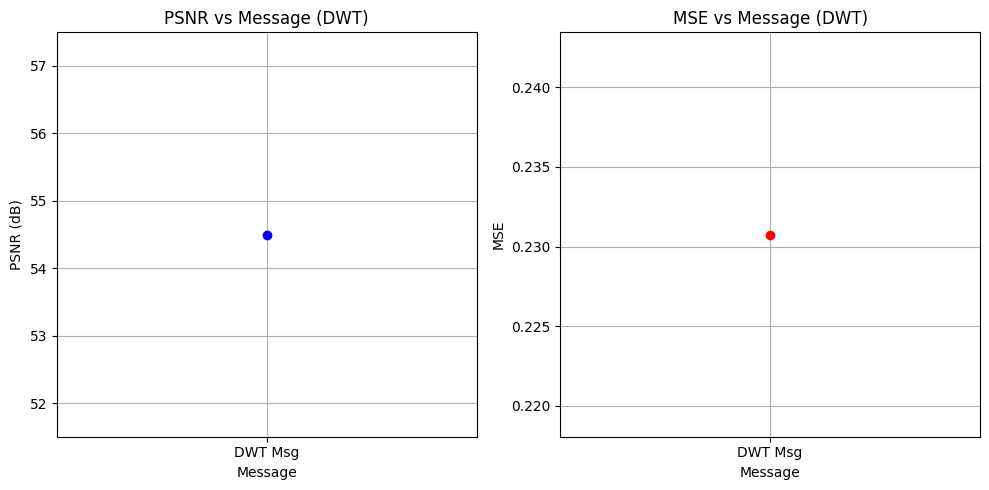

In [3]:
import matplotlib.pyplot as plt


def calculate_mse_psnr(original, modified):
    original = original.astype(np.float32)
    modified = modified.astype(np.float32)
    mse = np.mean((original - modified) ** 2)
    if mse == 0:
        psnr = float('inf')
    else:
        max_pixel = 255.0
        psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return mse, psnr

mse, psnr = calculate_mse_psnr(original, stego_img)
print(f"MSE: {mse:.10f}, PSNR: {psnr:.4f} dB")

# Plotting
psnr_values = [psnr]
mse_values = [mse]
message_labels = ["DWT Msg"]

plt.figure(figsize=(10, 5))

# PSNR Plot
plt.subplot(1, 2, 1)
plt.plot(message_labels, psnr_values, marker='o', color='blue')
plt.title('PSNR vs Message (DWT)')
plt.xlabel('Message')
plt.ylabel('PSNR (dB)')
plt.grid(True)

# MSE Plot
plt.subplot(1, 2, 2)
plt.plot(message_labels, mse_values, marker='o', color='red')
plt.title('MSE vs Message (DWT)')
plt.xlabel('Message')
plt.ylabel('MSE')
plt.grid(True)

plt.tight_layout()
plt.show()